In [1]:
import pyart
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import xarray as xr
import cartopy.feature as cfeature
import datetime

import products
import sort_radar
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from time import process_time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.io.shapereader as shpreader


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
reader = shpreader.Reader('SC_municipios_2021.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

In [39]:
#20230812 05 48 04 -27.2782 -52.6926#
#20230812 04 12 04 -26.8300 -52.9779# 
#20230812 05 00 04 -26.9053 -52.5932#
#20230812 05 30 04 -27.1646 -52.8822#
#20230812 05 42 04 -27.1848 -52.8077# 
#20230812 07 18 04 -27.1169 -52.3162#

dia = '20230812'
hora ='05'
min = '42'
sec = '04'
radar = pyart.aux_io.read_gamic(f'dados2/chapeco/CHP-{dia}{hora}{min}{sec}.HDF5')

site_lon = -52.8077# longitude in degrees
site_lat = -27.1848# latitdue in degrees
radar_lat = radar.latitude["data"][0]
radar_lon = radar.longitude["data"][0]

In [40]:

year = 2023
month = 8
day = 12
# Inicialização
g = 0
d = 0
c = int(hora) - 1
minu = int(min)
time_list = []  # Lista para armazenar os tempos
data_list = []  # Lista para armazenar os datasets de cada tempo

while g < 24:
    # Ajuste de minutos e horas
    if minu >= 60:
        c += 1
        minu -= 60

    # Construção do nome do arquivo e leitura do radar
    if 10 > c and minu > 10:
        radar = pyart.aux_io.read_gamic(f'dados2/chapeco/CHP-{dia}0{c}{minu}{sec}.HDF5')
        minu += 6
    if 10 > c and minu < 10:
        radar = pyart.aux_io.read_gamic(f'dados2/chapeco/CHP-{dia}0{c}0{minu}{sec}.HDF5')
        minu += 6
    if c >= 10 and minu < 10:
        radar = pyart.aux_io.read_gamic(f'dados2/chapeco/CHP-{dia}{c}0{minu}{sec}.HDF5')
        minu += 6
    if c >= 10 and minu > 10:
        radar = pyart.aux_io.read_gamic(f'dados2/chapeco/CHP-{dia}{c}{minu}{sec}.HDF5')
        minu += 6

    # Criação do tempo atual
    if minu == 60:
        minu = minu -60
        c += 1
    current_time = datetime.datetime(year=year, month=month, day=day, hour=c, minute=minu, second=4)
    time_list.append(current_time)

    # Processamento dos dados do radar
    ds = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon)
    ds2 = pyart.util.columnsect.get_field_location(radar, site_lat + 0.005, site_lon + 0.005)
    ds3 = pyart.util.columnsect.get_field_location(radar, site_lat + 0.005, site_lon - 0.005)
    ds4 = pyart.util.columnsect.get_field_location(radar, site_lat - 0.005, site_lon + 0.005)
    ds5 = pyart.util.columnsect.get_field_location(radar, site_lat - 0.005, site_lon - 0.005)
    ds6 = pyart.util.columnsect.get_field_location(radar, site_lat + 0.005, site_lon)
    ds7 = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon + 0.005)
    ds8 = pyart.util.columnsect.get_field_location(radar, site_lat - 0.005, site_lon)
    ds9 = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon - 0.005)

    # Cálculo das médias
    refle = np.max([ds.corrected_reflectivity[:].values, ds2.corrected_reflectivity[:].values, ds3.corrected_reflectivity[:].values, ds4.corrected_reflectivity[:].values, ds5.corrected_reflectivity[:].values, ds6.corrected_reflectivity[:].values, ds7.corrected_reflectivity[:].values, ds8.corrected_reflectivity[:].values, ds9.corrected_reflectivity[:].values], axis=0)
    rhohv = np.min([ds.cross_correlation_ratio[:].values, ds2.cross_correlation_ratio[:].values, ds3.cross_correlation_ratio[:].values, ds4.cross_correlation_ratio[:].values, ds5.cross_correlation_ratio[:].values, ds6.cross_correlation_ratio[:].values, ds7.cross_correlation_ratio[:].values, ds8.cross_correlation_ratio[:].values, ds9.cross_correlation_ratio[:].values], axis=0)
    velo = np.max([ds.corrected_velocity[:].values, ds2.corrected_velocity[:].values, ds3.corrected_velocity[:].values, ds4.corrected_velocity[:].values, ds5.corrected_velocity[:].values, ds6.corrected_velocity[:].values, ds7.corrected_velocity[:].values, ds8.corrected_velocity[:].values, ds9.corrected_velocity[:].values], axis=0)
    kdp = np.max([ds.corrected_differential_phase[:].values, ds2.corrected_differential_phase[:].values, ds3.corrected_differential_phase[:].values, ds4.corrected_differential_phase[:].values, ds5.corrected_differential_phase[:].values, ds6.corrected_differential_phase[:].values, ds7.corrected_differential_phase[:].values, ds8.corrected_differential_phase[:].values, ds9.corrected_differential_phase[:].values], axis=0)
    zdr = np.max([ds.corrected_differential_reflectivity[:].values, ds2.corrected_differential_reflectivity[:].values, ds3.corrected_differential_reflectivity[:].values, ds4.corrected_differential_reflectivity[:].values, ds5.corrected_differential_reflectivity[:].values, ds6.corrected_differential_reflectivity[:].values, ds7.corrected_differential_reflectivity[:].values, ds8.corrected_differential_reflectivity[:].values, ds9.corrected_differential_reflectivity[:].values], axis=0)
    dsm = xr.Dataset(
        data_vars=dict(
            corrected_reflectivity=(["time", "Altura"], [refle]),
            cross_correlation_ratio=(["time", "Altura"], [rhohv]),
            corrected_velocity=(["time", "Altura"], [velo]),
            corrected_differential_phase=(["time", "Altura"], [kdp]),
            corrected_differential_reflectivity=(["time", "Altura"], [zdr])
        ),
        coords=dict(
            time=[current_time],  # Coordenada de tempo
            Altura=ds.height[:].values  # Coordenada de altura
        )
    )

    # Adiciona o dataset à lista
    data_list.append(dsm)

    # Incrementa os contadores
    g += 1
    d += 1

# Combina todos os datasets em um único dataset com dimensão de tempo
final_ds = xr.concat(data_list, dim="time")

# Exibe o dataset final


C:\Users\victo\miniconda3\lib\site-packages\pyart\util\columnsect.py:389: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da_base = xr.DataArray(base_time, name="base_time")
C:\Users\victo\miniconda3\lib\site-packages\pyart\util\columnsect.py:389: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArra

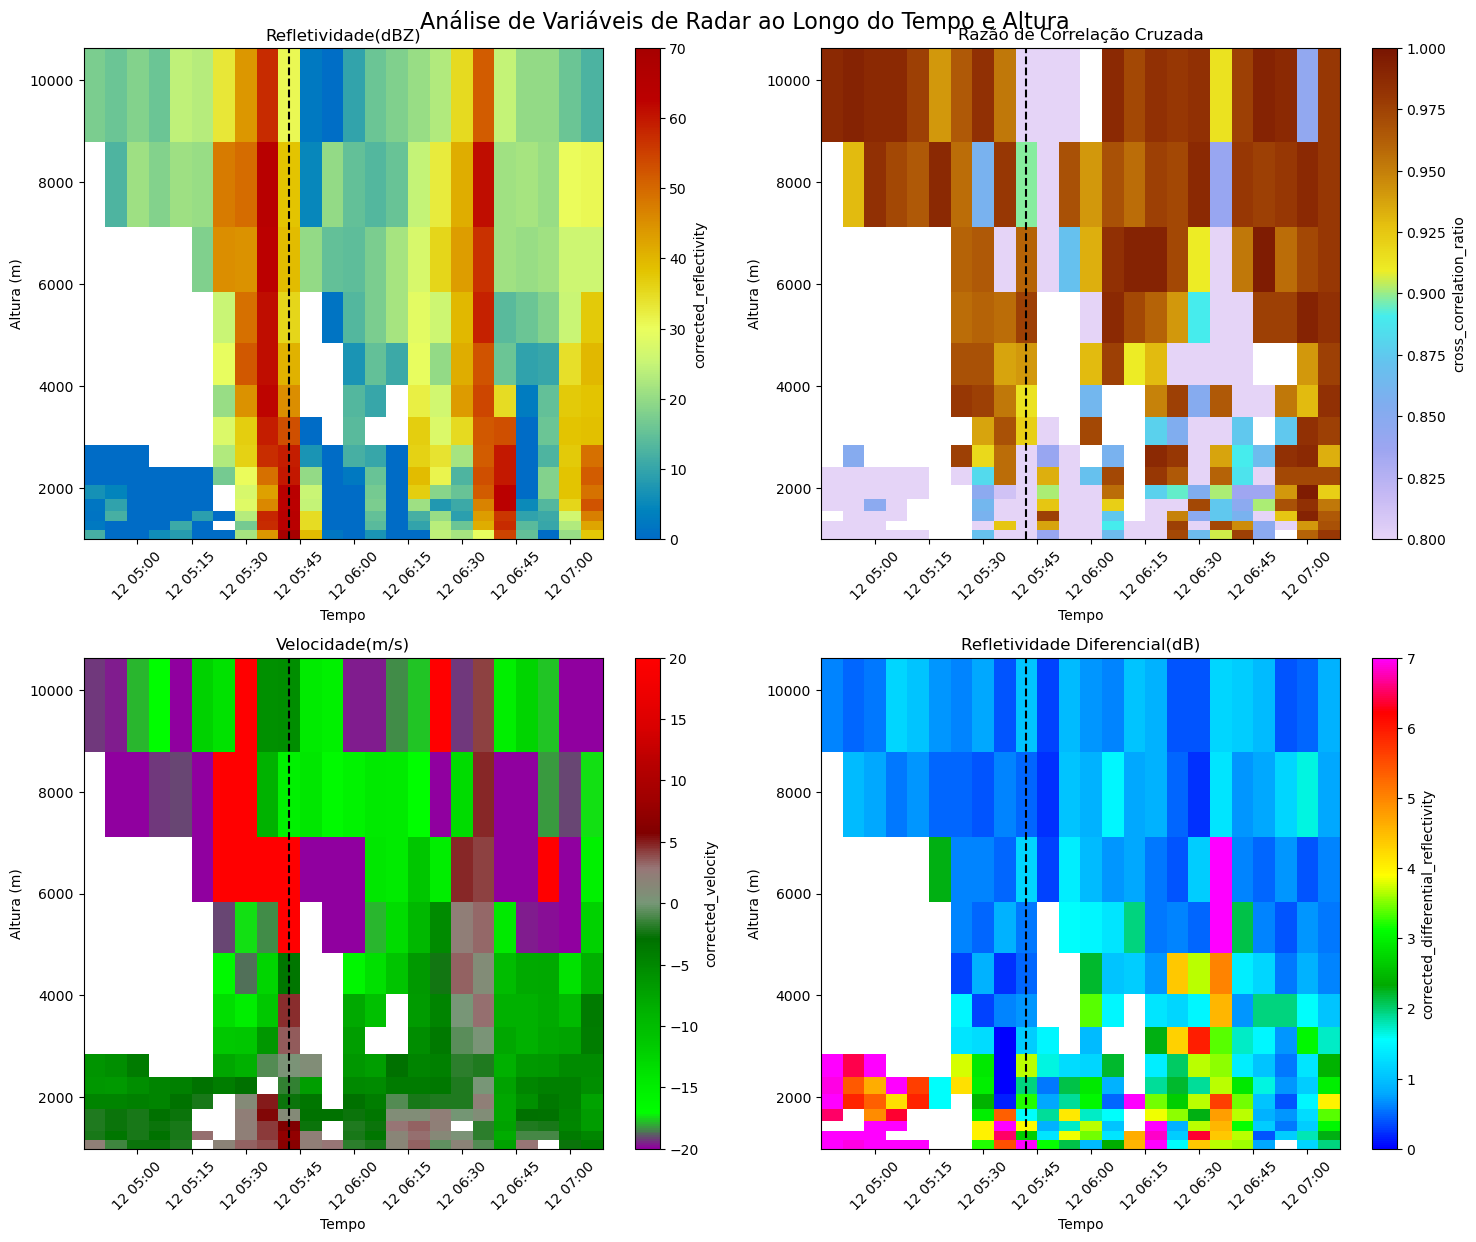

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))  # 3 linhas, 2 colunas
fig.suptitle('Análise de Variáveis de Radar ao Longo do Tempo e Altura', fontsize=16)

horario_linha = np.datetime64('2023-08-12T05:42')  # Ajuste a data conforme necessário

# Função para plotar uma variável em um subplot específico usando pcolormesh
def plot_variable(ax, dataset, variable_name, title, vmin, vmax, cmap='viridis'):
    # Usa pcolormesh para plotar
    mesh = ax.pcolormesh(dataset['time'], dataset['Altura'], dataset[variable_name].T, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax, label=variable_name)
    ax.set_title(title)
    ax.set_xlabel('Tempo')
    ax.axvline(x=horario_linha, color='black', linestyle='--', label='07:30')
    ax.set_ylabel('Altura (m)')
    ax.tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo x

# Plotando cada variável em seu respectivo subplot
plot_variable(axes[0, 0], final_ds, 'corrected_reflectivity', 'Refletividade(dBZ)', 
              vmin=0, vmax=70, cmap="pyart_HomeyerRainbow")
plot_variable(axes[0, 1], final_ds, 'cross_correlation_ratio', 'Razão de Correlação Cruzada', 
              vmin=0.8, vmax=1.0, cmap="pyart_LangRainbow12")
plot_variable(axes[1, 0], final_ds, 'corrected_velocity', 'Velocidade(m/s)', 
              vmin=-20, vmax=20, cmap='pyart_NWSVel')
plot_variable(axes[1, 1], final_ds, 'corrected_differential_reflectivity', 'Refletividade Diferencial(dB)', 
              vmin=0, vmax=7, cmap=pyart.graph.cm.RefDiff)


fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 0])
# Ajusta o layout para evitar sobreposição
plt.tight_layout()

plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\series.png', bbox_inches='tight', dpi=500)

In [32]:
final_ds


<xarray.Dataset>
Dimensions:                              (time: 24, Altura: 14)
Coordinates:
  * time                                 (time) datetime64[ns] 2023-08-12T06:...
  * Altura                               (Altura) float64 1.127e+03 ... 1.122...
Data variables:
    corrected_reflectivity               (time, Altura) float64 42.71 ... 7.347
    cross_correlation_ratio              (time, Altura) float64 nan ... nan
    corrected_velocity                   (time, Altura) float64 nan ... 29.67
    corrected_differential_phase         (time, Altura) float64 nan nan ... nan
    corrected_differential_reflectivity  (time, Altura) float64 nan ... 1.804

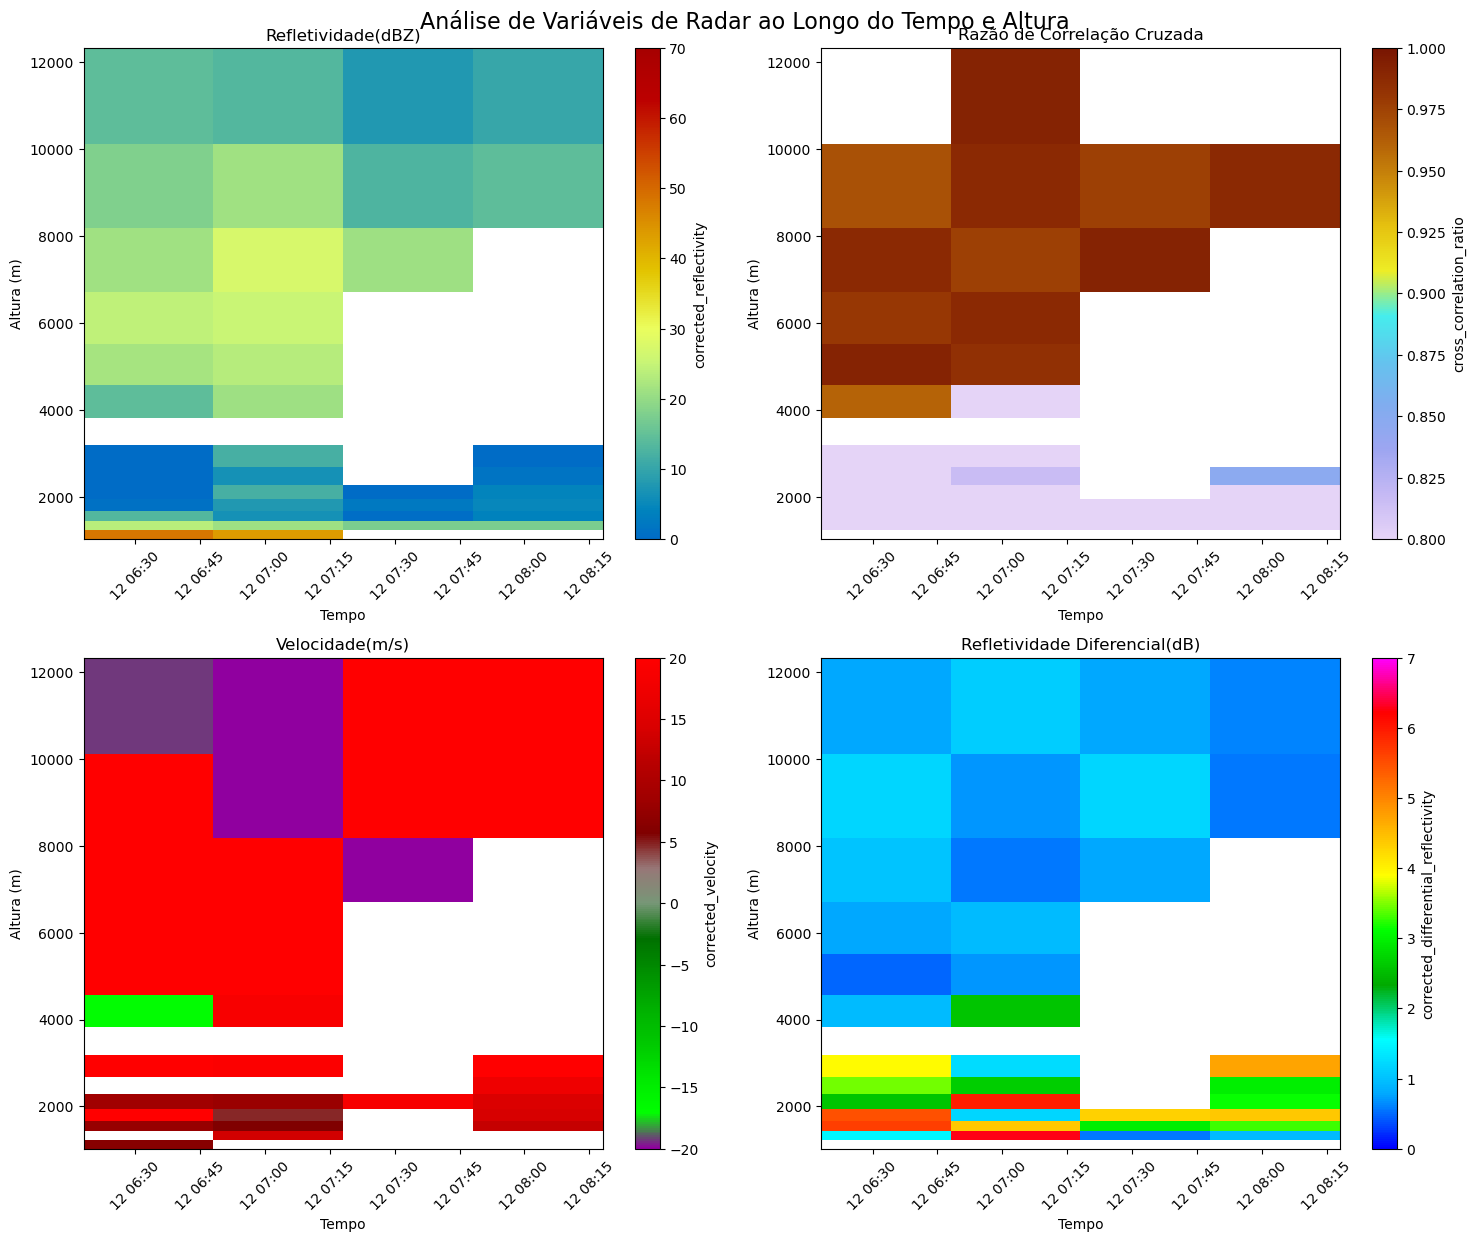

In [29]:
# Cria uma figura com subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))  # 3 linhas, 2 colunas
fig.suptitle('Análise de Variáveis de Radar ao Longo do Tempo e Altura', fontsize=16)

# Função para plotar uma variável em um subplot específico usando pcolormesh
def plot_variable(ax, dataset, variable_name, title, vmin, vmax, cmap='viridis'):
    mesh = ax.pcolormesh(dataset['time'], dataset['Altura'], dataset[variable_name].T, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax, label=variable_name)
    ax.set_title(title)
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Altura (m)')
    ax.tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo x

# Plotando cada variável em seu respectivo subplot
plot_variable(axes[0, 0], final_ds, 'corrected_reflectivity', 'Refletividade(dBZ)', 
              vmin=0, vmax=70, cmap="pyart_HomeyerRainbow")
plot_variable(axes[0, 1], final_ds, 'cross_correlation_ratio', 'Razão de Correlação Cruzada', 
              vmin=0.8, vmax=1.0, cmap="pyart_LangRainbow12")
plot_variable(axes[1, 0], final_ds, 'corrected_velocity', 'Velocidade(m/s)', 
              vmin=-20, vmax=20, cmap='pyart_NWSVel')
#plot_variable(axes[1, 1], final_ds, 'corrected_differential_phase', 'Fase Diferencial(graus)', 
#              vmin=-180, vmax=180, cmap=pyart.graph.cm.RefDiff)
plot_variable(axes[1, 1], final_ds, 'corrected_differential_reflectivity', 'Refletividade Diferencial(dB)', 
              vmin=0, vmax=7, cmap=pyart.graph.cm.RefDiff)

# Remove o subplot vazio (se houver)
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 0])
# Ajusta o layout para evitar sobreposição
plt.tight_layout()

plt.show()
fig.savefig(f'C:\\Users\\victo\\Desktop\\teste\\series.png', bbox_inches='tight', dpi=500)